# import libraries

In [1]:
%matplotlib inline

# python wrapper for cpp code
from qihmc import Ising

import numpy as np
import matplotlib.pyplot as plt

# MDS problem to qubo map (install the other repo)
from qlp.mds.qubo import get_mds_qubo, QUBO_to_Ising
from qlp.mds.graph_tools import get_plot_mpl
import qlp.mds.graph_tools as gt

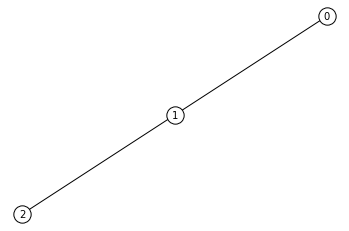

In [2]:
graph,_ = gt.generate_nn_graph(3)
get_plot_mpl(graph)
plt.show()

Set up the QUBO and ising model. Specify the penalty term

In [3]:
penalty = 2
nodes = set([i for i, _ in graph] + [j for _, j in graph])
n_nodes = len(nodes)

qubo = get_mds_qubo(graph, penalty=penalty, triangularize=True)
J, h, c = QUBO_to_Ising(qubo.todense())

offset = c + penalty * n_nodes

print(J)
print(h)
print(offset)

[[ 0.  2.  1. -1. -1. -2.  0.]
 [ 0.  0.  2. -1. -1. -2. -1.]
 [ 0.  0.  0.  0. -1. -2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
[-2.5 -3.5 -2.5  1.   2.   4.   1. ]
11.5


Add parameters used for ising model

In [4]:
beta = 3.5
md_steps = 10
ergodicity_jumps = -100

In [5]:
print(Ising.__doc__)

Class wraps HMC solver for spin-glass Hamiltonian such that

    H[psi] = psi@J@psi + h@psi + offset

    and the partition function corresponds to

    Z = sum(exp(- beta H[psi]), psi)


    Attributes:
        J: Spin coupling matrix
        h: External magentic field
        offset: Offset of Hamiltonian
        beta: Inverse termperature
        md_steps: Number of molecular dynamics steps
        ergodicity_jumps: Parameter which helps with erogdicity. Defaults to -100

    Note:
        Multiplies with minus one before inserting in CPP class.

    Todo:
        * Test
        * Think about matrix symmetry
    


This is equivalent to your read in and `.initialize()` call.

I have not included the factor of `1/2` you have in your notes when setting up
$$
    K_{sym} = K^T + K
$$

In [6]:
ising = Ising(J, h, offset, beta, md_steps, ergodicity_jumps)

('J =', array([[-0., -2., -1.,  1.,  1.,  2., -0.],
       [-2., -0., -2.,  1.,  1.,  2.,  1.],
       [-1., -2., -0., -0.,  1.,  2.,  1.],
       [ 1.,  1., -0., -0., -0., -0., -0.],
       [ 1.,  1.,  1., -0., -0., -2., -0.],
       [ 2.,  2.,  2., -0., -2., -0., -0.],
       [-0.,  1.,  1., -0., -0., -0., -0.]]))
('h_sym =', array([ 2.5,  3.5,  2.5, -1. , -2. , -4. , -1. ]))
('offset =', 11.5)
('C_in =', 6.869786498565077)
('beta =', 3.5)


First anneal, starting at some "hot" temperature and cool to the target temperature

In [7]:
init_beta=.2
n_therm = 50000
md_steps = 10
ising.anneal(init_beta,beta,n_therm, md_steps,ergodicity_jumps)  # this always accepts

Now thermalize at target temperature for some time

In [8]:
n_therm = 500000
md_steps = 10
# we can continue to thermalize (ie always accept)
ising.thermalize(beta, n_therm, md_steps, ergodicity_jumps)
md_steps = 5
# we can now include accept/reject for some steps
ising.run_hmc(beta,n_therm,md_steps,ergodicity_jumps,10)

Run HMC (see `quboIsingHMC.cpp` line 252+)

This first clears and then populates the 
```
ising.energy
ising.acceptance
ising.configs
```
members

In [9]:
n_trajectories = 500000
save_frequency = 10
md_steps = 10
ising.run_hmc(beta,n_trajectories,md_steps,ergodicity_jumps,save_frequency)

Compute ensemble averages

In [10]:
e = np.mean(ising.energy)
p = np.mean(ising.acceptance)
psi = np.mean(ising.configs, axis=0) / np.sqrt(ising.beta) - ising.k

ppsi = psi.round(2)
e_gs =  ppsi @ J @ ppsi + h @ ppsi + offset

print("Energy =", e)
print("Acceptance =", p)
print("Ground state =", ppsi)
print(f"Energy from groundstate = {e_gs:1.3f}")

Energy = 2.1952967068811615
Acceptance = 0.9940521189576209
Ground state = [ 0.98 -1.01  0.99 -1.    1.01 -0.99 -0.95]
Energy from groundstate = 2.093


Note that I played around with a few parameters. As a matter of fact, I get stuck in a 2 node ground state solution if I run with the same parameters as the cpp file. Not sure if something goes wrong.

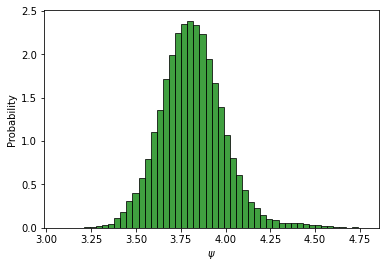

In [11]:
n, bins, patches = plt.hist(np.mean(ising.configs,axis=1),50, 
                            edgecolor='Black', density=1, facecolor='green', 
                            alpha=0.75)

plt.xlabel(r'$\psi$')
plt.ylabel('Probability')
plt.grid(False)

plt.show()

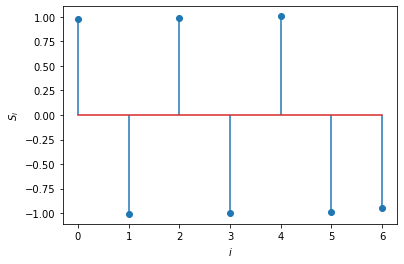

In [12]:
plt.stem(np.array([i for i in range(ising.Lambda)]),
         np.mean(ising.configs,axis=0)/ np.sqrt(ising.beta) - ising.k,
         use_line_collection=True)

plt.xlabel(r'$i$')
plt.ylabel(r'$S_i$')

plt.show()

# Anneal w/o H, and then turn on H adiabatically

Now let's anneal without the external field

In [159]:
init_beta=.2
target_beta = 3.5
n_therm = 500000
md_steps = 10
ergodicity_jumps = 100
ising.annealNoH(init_beta,target_beta,n_therm, md_steps,ergodicity_jumps)

Now turn on the external field adiabatically

In [192]:
n_therm = 500000
md_steps = 10
ising.turnOnH(target_beta,n_therm, md_steps,ergodicity_jumps)

Now run regular hmc

In [193]:
n_trajectories = 1000000
save_frequency = 10
md_steps = 2
ergodicity_jumps = -1
ising.run_hmc(target_beta,n_trajectories,md_steps,ergodicity_jumps,save_frequency)

Compute ensemble averages:

In [194]:
e = np.mean(ising.energy)
p = np.mean(ising.acceptance)
psi = np.mean(ising.configs, axis=0) / np.sqrt(target_beta) - ising.k

ppsi = psi.round(2)
e_gs =  ppsi @ J @ ppsi + h @ ppsi + offset

print("Energy =", e)
print("Acceptance =", p)
print("Ground state =", ppsi)
print(f"Energy from groundstate = {e_gs:1.3f}")

Energy = 1.0712437771640602
Acceptance = 0.7919860801391987
Ground state = [-1.01  0.99 -1.01 -1.   -0.99 -0.99 -1.  ]
Energy from groundstate = 1.027


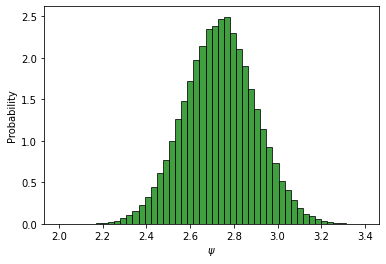

In [195]:
n, bins, patches = plt.hist(np.mean(ising.configs,axis=1),50, 
                            edgecolor='Black', density=1, facecolor='green', 
                            alpha=0.75)

plt.xlabel(r'$\psi$')
plt.ylabel('Probability')
plt.grid(False)

plt.show()

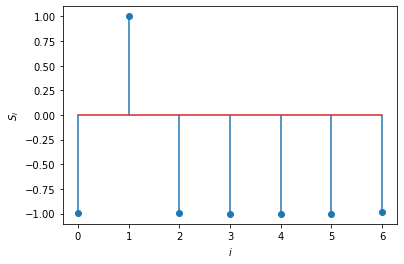

In [174]:
plt.stem(np.array([i for i in range(ising.Lambda)]),
         np.mean(ising.configs,axis=0)/ np.sqrt(target_beta) - ising.k,
         use_line_collection=True)

plt.xlabel(r'$i$')
plt.ylabel(r'$S_i$')

plt.show()

# Now anneal AND turn on H adiabatically at the same time

In [40]:
init_beta=.2
target_beta = 3.5
n_therm = 1000000
md_steps = 10
ergodicity_jumps = 100
ising.annealAndTurnOnH(init_beta,target_beta,n_therm, md_steps,ergodicity_jumps)
# This anneals and turns on H at the same time (this does accept/reject all the time)
# It sets H=0 @ init_beta, then takes n_therm steps to reach H @ target_beta

In [41]:
n_trajectories = 1000000
save_frequency = 10
md_steps = 2
ergodicity_jumps = -1
ising.run_hmc(target_beta,n_trajectories,md_steps,ergodicity_jumps,save_frequency)
# this just does accept/reject at the target temperature

In [42]:
e = np.mean(ising.energy)
p = np.mean(ising.acceptance)
psi = np.mean(ising.configs, axis=0) / np.sqrt(target_beta) - ising.k

ppsi = psi.round(2)
e_gs =  ppsi @ J @ ppsi + h @ ppsi + offset

print("Energy =", e)
print("Acceptance =", p)
print("Ground state =", ppsi)
print(f"Energy from groundstate = {e_gs:1.3f}")

Energy = 1.0216081713894496
Acceptance = 0.7917749822501774
Ground state = [-1.    1.   -1.01 -1.   -1.   -1.   -1.  ]
Energy from groundstate = 0.975
